#### Combining data_pipeline and simple_example

In [1]:
import sys
sys.path.insert(1,'/Users/n593117/Desktop/MOO/wtte-rnn/python/')
sys.path.insert(0,'/anaconda/lib/python2.7/site-packages/')
print(sys.path)

['/anaconda/lib/python2.7/site-packages/', '', '/Users/n593117/Desktop/MOO/wtte-rnn/python/', '/Library/Frameworks/SQLite3.framework/Versions/C/Python/2.7', '/Library/Frameworks/GEOS.framework/Versions/3/Python/2.7/site-packages', '/Library/Python/2.7/site-packages/matplotlib-override', '/Library/Frameworks/GDAL.framework/Versions/1.11/Python/2.7/site-packages', '/Library/Python/2.7/site-packages/pip-8.0.2-py2.7.egg', '/Library/Python/2.7/site-packages/six-1.10.0-py2.7.egg', '/Library/Python/2.7/site-packages/wheel-0.29.0-py2.7.egg', '/Library/Python/2.7/site-packages/patsy-0.4.1-py2.7.egg', '/Library/Python/2.7/site-packages/pandas-0.17.1-py2.7-macosx-10.10-intel.egg', '/Library/Python/2.7/site-packages/pymc-2.3.6-py2.7-macosx-10.10-intel.egg', '/Users/n593117/pgmult', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python

In [2]:
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload')
sys.path.remove('/Library/Python/2.7/site-packages')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python')
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/PyObjC') 
sys.path.remove('/Library/Python/2.7/site-packages/IPython/extensions')
                

In [3]:
sys.path.remove('/Library/Frameworks/GEOS.framework/Versions/3/Python/2.7/site-packages') 
sys.path.remove('/Library/Python/2.7/site-packages/matplotlib-override')
sys.path.remove('/Library/Frameworks/GDAL.framework/Versions/1.11/Python/2.7/site-packages')
sys.path.remove('/Library/Python/2.7/site-packages/pip-8.0.2-py2.7.egg')
sys.path.remove('/Library/Python/2.7/site-packages/six-1.10.0-py2.7.egg') 
sys.path.remove('/Library/Python/2.7/site-packages/wheel-0.29.0-py2.7.egg') 
sys.path.remove('/Library/Python/2.7/site-packages/patsy-0.4.1-py2.7.egg')
sys.path.remove('/Library/Python/2.7/site-packages/pandas-0.17.1-py2.7-macosx-10.10-intel.egg')
sys.path.remove('/Library/Python/2.7/site-packages/pymc-2.3.6-py2.7-macosx-10.10-intel.egg')
sys.path.remove('/Library/Frameworks/SQLite3.framework/Versions/C/Python/2.7')
sys.path.remove('/Users/n593117/.ipython')

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

import tensorflow as tf
from keras import backend as k
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.layers import Activation
from keras.layers import Masking
from keras.layers import LocallyConnected1D
from keras.optimizers import RMSprop
from keras.callbacks import History, TensorBoard

print(tf.__version__) 

import wtte.weibull as weibull
import wtte.wtte as wtte

#from IPython import display

ImportError: No module named gzip

In [3]:
pd.options.display.max_rows = 10

path = "~/tensorflow"
df = pd.read_csv(path+'/tensorflow.log',error_bad_lines=False)
df.fillna(0,inplace=True)


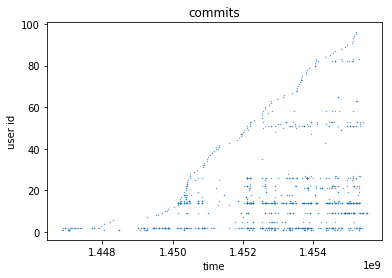

In [4]:
# Create a fictitious integer id based on first commit.
# (order has no downstream implications except easy plotting.)

# group by: split or group by author name, 
# then apply some function to each group - in this case it's finding the min
# of a given author's commit + their name, 
# then rank those strings using the 'dense'  method, 
# which ensures we pick the lowest rank in group and that 
# rank always increases by 1 between groups
id_col = 'id'
df[id_col] = df.groupby(["author_name"], group_keys=False).\
               apply(lambda g: g.time_sec.min().\
               astype(str)+g.author_name).\
               rank(method='dense').astype(int)

df.plot(kind='scatter', x='time_sec', y='id',s=0.1)
plt.title('commits')
plt.xlabel('time')
plt.ylabel('user id')
plt.show()
    
df.sort_values(['id','time_sec'],inplace=True)

In [5]:
# dt = wallclock time, global timestep i.e 2012-01-01,...
abs_time_col='dt'
# t  = elapsed time, local timestep i.e 0,1,2,10,...
t_col = 't_elapsed' 
discrete_time = True
# Does the explicit rows in dataset cover each sequence whole life?
sequences_terminated = False
numeric_cols = ["n_commits","files_changed", "lines_inserted","lines_deleted"]

if discrete_time:
    # Convert nanosec to date
    # without selecting the dt.date the "abs_time_col" column would have
    # contained full dates, such as "2015-11-07 02:37:11"
    df[abs_time_col] = pd.to_datetime(df['time_sec'],unit='s').dt.date
    # Last timestep may be incomplete/not fully measured so drop it.
    df = df.loc[df[abs_time_col] <= df[abs_time_col].max()]
else:
    # Left as human readable format for readability.
#    df[abs_time_col] = pd.to_datetime(df['time_sec'],unit='s')
    df[abs_time_col] = df['time_sec']

# here we have the special case that a row indicates an event:
df['n_commits'] = 1

In [6]:
# Aggregate over the new datetime interval to get id,dt = unique key value pair
# dict.fromkeys creates a dictionary of key (numeric column names) - value ('sum' for all) pairs

# so we are groupping by id (like 1), author name (why?), and dt (like 2015-11-07)
# and then use agg() to calculate some statistics per group 
# aggregation instructions are in the form of a dictionary:
# use the dictionary keys to specify the columns on which it'll operate
# and the values specify the functions to run
df = df.groupby([id_col,'author_name',abs_time_col],as_index=False).\
    agg(dict.fromkeys(numeric_cols, "sum"))#.reset_index()

# event = if something special happened i.e commit.
df['event'] =  (df.n_commits>0).astype(int)

In [7]:
# so this basically added the endtime, which is the max of abs_time_col (=dt)
# and fills the values with 0's if a given id/author combination have no record for
# that time

if not sequences_terminated:
    # Assuming each sequence has its own start and is not terminated by last event:
    # Add last time that we knew the sequence was 'alive'.
    df = tr.df_join_in_endtime(df,
               per_id_cols=[id_col,'author_name'], 
               abs_time_col=abs_time_col,nanfill_val = 0)
    # Warning: fills unseen timesteps with 0


In [8]:
# Add "elapsed time" t_elapsed = 0,3,99,179,.. for each group (=user). 
# t_col = t_elapsed was defined earlier
df[t_col] = df.groupby([id_col], group_keys=False).apply(lambda g: g.dt-g.dt.min())

In [9]:
if discrete_time:
    # Make it a well-behaved integer:
    # infer the discrete stepsize as the first component of the timedelta
    # because otherwise it would have been something like "4 days", "8 days", etc.
    df[t_col] = df[t_col].dt.components.ix[:,0] 
else:
    # Add t_ix = 0,1,2,3,.. and set as primary user-time indicator.
    # if we pass t_elapsed as t_col downstream we'll pad between observed secs
    df['t_ix'] = df.groupby([id_col])[t_col].rank(method='dense').astype(int)-1
    t_col = 't_ix'

In [10]:
# df_to_padded calls df_to_array(df, column_names = ['event'], nanpad_right = True)
# with id_col = 'id' and t_col = t_elapsed 

# now df_to_array does the following:
# - take df with columns column_names, as well as 'id' and 't'
# - if 't' is non-contiguous then steps in between t's are padded with zeros
# - if nanpad_right = True then 'nans' are inserted to complete the series

# so what this does is, it converts a pandas df (id, t, col1, col2, ...) to array indexed
# (id, t, col)

events = tr.df_to_padded(df,['event'],t_col=t_col).squeeze()
the_seq_lengths = df[['id', 't_elapsed']].groupby('id').aggregate('max')['t_elapsed'].values + 1
print(the_seq_lengths)
print(events.shape)
print(events[95])
# there should be 101 days for the oldest user, because there are that many days between
# their first commit on 2015-11-07 and the last commit (not necessarily by them) on 2016-02-15
# so events will be of shape (number of users, 101)

[101 101  89  88  86  85  74  71  69  68  67  65  63  63  63  63  62  61
  61  61  61  61  60  60  60  60  60  59  58  57  55  55  55  54  54  54
  53  52  52  51  51  50  47  44  43  43  43  42  42  41  41  40  40  38
  36  36  36  35  35  35  33  33  33  31  29  28  26  25  24  24  24  23
  23  23  22  21  21  21  20  18  18  18  18  15  13  12  12   9   8   8
   6   6   6   5   5   5]
(96, 101)
[  1.   0.   0.   0.   0.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


In [11]:
if discrete_time:
#    padded_t = np.ones_like(events).cumsum(axis=1)-1
    padded_t = None
else:
    padded_t = tr.df_to_padded(df,['t_elapsed'],t_col=t_col).squeeze()

    
# padded_tte computes the time from a given point in array "events"
# to the next event = 1
padded_tte = tr.padded_events_to_tte(events,discrete_time=discrete_time,t_elapsed=padded_t)
print(padded_tte[95])
# padded_u returns all 1's until it hits the last known event, after which
# it's all 0's 
padded_u = tr.padded_events_to_not_censored(events,discrete_time)
print(padded_u[95])

# this returns the actual lengths of sequences for different users (without the padded nans)
seq_lengths = (False==np.isnan(events)).sum(1)
print(seq_lengths[95])

[  0.   4.   3.   2.   1.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[  1.   0.   0.   0.   0.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan 

In [12]:
print(seq_lengths)

[101 101  89  88  86  85  74  71  69  68  67  65  63  63  63  63  62  61
  61  61  61  61  60  60  60  60  60  59  58  57  55  55  55  54  54  54
  53  52  52  51  51  50  47  44  43  43  43  42  42  41  41  40  40  38
  36  36  36  35  35  35  33  33  33  31  29  28  26  25  24  24  24  23
  23  23  22  21  21  21  20  18  18  18  18  15  13  12  12   9   8   8
   6   6   6   5   5   5]


In [13]:
# Hide the truth from the model:
feature_cols = ["n_commits","files_changed", "lines_inserted","lines_deleted"]
# we used this functionality before to create events
## like this: events = tr.df_to_padded(df,['event'],t_col=t_col).squeeze()
# but now we are doing this for feature_cols, not ['events']

x_ = tr.df_to_padded(df,feature_cols,t_col=t_col)
if discrete_time:
    x_ = tr.shift_discrete_padded_features(x_)

# so x_ has the 4 features for the 96 user id's, and 101 timesteps (days) 
# the features are now padded with nans if nothing is available after a certain day
print(x_.shape)
print(x_[0].shape)

(96, 101, 4)
(101, 4)


In [14]:
n_timesteps = x_.shape[1]
print("n_timesteps = ",n_timesteps)
n_features  = x_.shape[-1]
print("n_fatures = ",n_features)
n_sequences = x_.shape[0]
print("n_sequences = ",n_sequences)
seq_lengths = (False==np.isnan(x_[:,:,0])).sum(1)

y_ = np.stack([padded_tte,padded_u],axis=-1)
#del padded_tte, padded_u
print("padded_tte type = ",type(padded_tte), " of size ",padded_tte.shape)
print("padded_u type = ",type(padded_u)," of size ",padded_u.shape)
print("Y_ is of shape ",y_.shape)

new_ix    = np.random.permutation(y_.shape[0]).astype(int)  # Randomly sample array 
n_test    = np.floor(y_.shape[0]/4.0).astype(int)           # ex split 25% testsplit

y_ = y_[new_ix,:,:]
x_ = x_[new_ix,:,:]
seq_lengths = seq_lengths[new_ix]
print("selected x_ shape = ",x_.shape," selected y_ shape = ",y_.shape)

('n_timesteps = ', 101)
('n_fatures = ', 4)
('n_sequences = ', 96)
('padded_tte type = ', <type 'numpy.ndarray'>, ' of size ', (96, 101))
('padded_u type = ', <type 'numpy.ndarray'>, ' of size ', (96, 101))
('Y_ is of shape ', (96, 101, 2))
('selected x_ shape = ', (96, 101, 4), ' selected y_ shape = ', (96, 101, 2))


In [15]:
# SPLIT into training/testing
x_train = x_[n_test:,:,:]
y_train = y_[n_test:,:,:]
x_test  = x_[:n_test,:,:]
y_test  = y_[:n_test,:,:]
print("x_train shape ",x_train.shape," x_test shape ",x_test.shape)
print("y_train shape ",y_train.shape," y_test shape ",y_test.shape)

seq_lengths_train =  (np.isnan(y_train).sum(2) == 0).sum(1).flatten()
seq_lengths_test  =  (np.isnan(y_test).sum(2) == 0).sum(1).flatten()
del x_, y_

# Sort each subset by seq length for pretty plots (OPTIONAL)
new_order = np.argsort(seq_lengths_train)
seq_lengths_train = seq_lengths_train[new_order]
x_train = x_train[new_order,:,:]
y_train = y_train[new_order,:,:]

new_order = np.argsort(seq_lengths_test)
seq_lengths_test = seq_lengths_test[new_order]
x_test = x_test[new_order,:,:]
y_test = y_test[new_order,:,:]
del new_order

# NORMALIZE
x_train,means,stds = tr.normalize_padded(x_train)
x_test,_,_         = tr.normalize_padded(x_test,means,stds)

n_test      = x_test.shape[0]
n_train     = x_train.shape[0]
n_features  = x_train.shape[2]
n_timesteps = y_train.shape[1]
    

('x_train shape ', (72, 101, 4), ' x_test shape ', (24, 101, 4))
('y_train shape ', (72, 101, 2), ' y_test shape ', (24, 101, 2))


In [16]:
# SANITIZE VALUES AND CREATE MASK (weights)
#y_train = np.concatenate([y_train[:,:,:],1.-np.isnan(y_train[:,:,1]).reshape(n_train,n_timesteps,1)],axis=-1)
mask_value = -1337

train_mask = False==np.isnan(y_train[:,:,0])
test_mask  = False==np.isnan(y_test[:,:,0])
print("train_mask is of type ",type(train_mask)," shape ",train_mask.shape)
print(train_mask[1])

('train_mask is of type ', <type 'numpy.ndarray'>, ' shape ', (72, 101))
[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


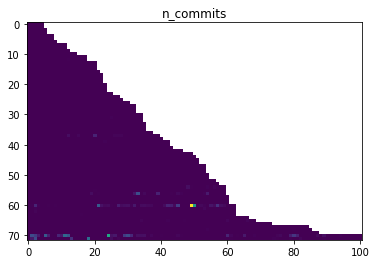

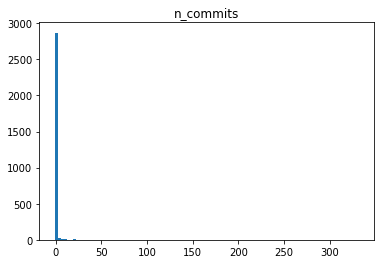

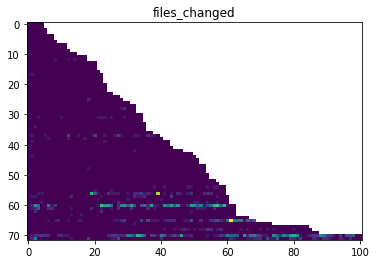

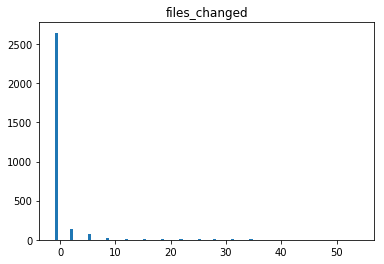

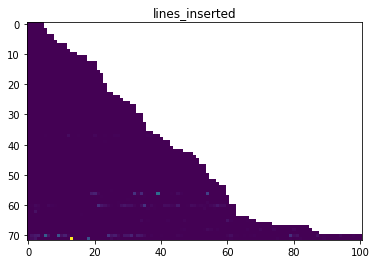

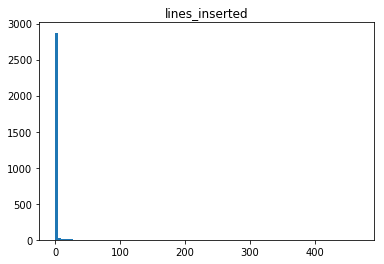

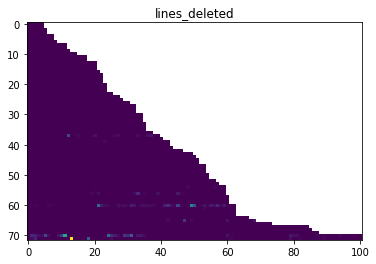

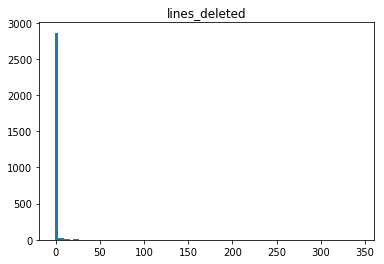

(72, 101, 4) float64
(24, 101, 4) float64
(72, 101, 2) float64
(24, 101, 2) float64


In [17]:
for f in xrange(n_features):
    plt.imshow(x_train[:,:,f],aspect='auto',interpolation="none")
    plt.title(feature_cols[f])
    plt.show()
    plt.hist(x_train[:,:,f][train_mask].flatten(),100)
    plt.title(feature_cols[f])
    plt.show()

y_train[np.isnan(y_train)] = mask_value
x_train[np.isnan(x_train)] = mask_value

y_test[np.isnan(y_test)] = mask_value
x_test[np.isnan(x_test)] = mask_value

print x_train.shape,x_train.dtype
print x_test.shape,x_test.dtype
print y_train.shape,y_train.dtype
print y_test.shape,y_test.dtype

In [18]:
np.random.seed(1)
# Store some history
history = History()
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=False, write_images=False)

# Start building the model
model = Sequential()
model.add(GRU(1, input_shape=(n_timesteps, n_features),return_sequences=True))

model.add(Dense(2))
# Simple exponential activation function works too:
# model.add(Activation(k.exp))

# .. compare with using tailored.
# Start at naive (ignoring censoring) geometric (beta=1) MLE:
init_alpha = -1.0/np.log(1.0-1.0/(np.mean(y_train[:,:,0])+1.0) )
init_alpha = 34.8626096973
print 'init_alpha: ',init_alpha
wtte_activation = wtte.output_activation(init_alpha=init_alpha,
                                             max_beta_value=4.0).activation

model.add(Activation(wtte_activation))
loss = wtte.loss(kind='discrete',use_weights=False,use_censoring=True).loss_function

model.compile(loss=loss, optimizer=RMSprop(lr=.01))#,sample_weight_mode="temporal")

model.summary()

init_alpha:  34.8626096973
Instructions for updating:
Use `tf.global_variables_initializer` instead.


InvalidArgumentError: You must feed a value for placeholder tensor 'gru_1_input' with dtype float
	 [[Node: gru_1_input = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'gru_1_input', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-29e130b42a8b>", line 8, in <module>
    model.add(GRU(1, input_shape=(n_timesteps, n_features),return_sequences=True))
  File "/anaconda/lib/python2.7/site-packages/keras/models.py", line 418, in add
    dtype=layer.dtype, name=layer.name + '_input')
  File "/anaconda/lib/python2.7/site-packages/keras/engine/topology.py", line 1388, in Input
    input_tensor=tensor)
  File "/anaconda/lib/python2.7/site-packages/keras/engine/topology.py", line 1299, in __init__
    name=self.name)
  File "/anaconda/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 349, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'gru_1_input' with dtype float
	 [[Node: gru_1_input = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### The below doesn't work - possible reasons are:
    --- init_alpha should be > 0 and initialization is important. Gradients explode if you're too far off. More censored data leads to higher probability of exploding grad initially.
    --- Learning rate is dependent on data and can be in magnitudes you didn't expect
    --- Varying length sequences has no clean implementation atm 
    --- Current solution: set n_timesteps = None and run training step with one input sequence (see cell after next)


In [22]:
np.random.seed(1)
model.fit(x_train, y_train,
          epochs=75, 
          batch_size=x_train.shape[0]/10, 
          verbose=2, 
          validation_data=(x_test, y_test),
          callbacks=[history],
#          callbacks=[history,tensorboard]
          )

Train on 72 samples, validate on 24 samples
Epoch 1/75
2s - loss: nan - val_loss: nan
Epoch 2/75
1s - loss: nan - val_loss: nan
Epoch 3/75
1s - loss: nan - val_loss: nan
Epoch 4/75


KeyboardInterrupt: 

In [41]:
#print(the_seq_lengths)
i = 63
print(y_train[i,:the_seq_lengths[i],:].shape)

(31, 2)


In [18]:
model2 = Sequential()

#GRU args: 1 = dimensionality of the output space
#         input_shape = (n_timesteps, n_features)
model2.add(GRU(10,input_shape=(31,4), return_sequences=True))

model2.add(Dense(2))
model2.add(Activation(k.exp))

init_alpha = 1
#print 'init_alpha: ',init_alpha
#wtte_activation = wtte.output_activation(init_alpha=init_alpha,
#                                             max_beta_value=4.0).activation

#model2.add(Activation(wtte_activation))
loss2 = wtte.loss(kind='discrete',use_weights=False,use_censoring=True).loss_function
model2.compile(loss=loss2, optimizer=RMSprop(lr=.1))#,sample_weight_mode="temporal")
model2.summary()

n_samples = 1
for i in xrange(n_samples):
    print(x_train[63,:the_seq_lengths[63],:].shape)
    print(y_train[63,:the_seq_lengths[63],:].shape)
    tmp = x_train[63,:the_seq_lengths[63],:].reshape(1,31,4)
    tmp2 = y_train[63,:the_seq_lengths[63],:].reshape(1,31,2)
    print(tmp2)
    #model2.fit(x_train[i,:the_seq_lengths[i],:],y_train[i,:the_seq_engths[i],:])
    model2.fit(tmp,tmp2,
                epochs=1,
                batch_size=1,
                verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 31, 10)            450       
_________________________________________________________________
dense_1 (Dense)              (None, 31, 2)             22        
_________________________________________________________________
activation_1 (Activation)    (None, 31, 2)             0         
Total params: 472.0
Trainable params: 472.0
Non-trainable params: 0.0
_________________________________________________________________
(31, 4)
(31, 2)
[[[  0.   1.]
  [ 12.   1.]
  [ 11.   1.]
  [ 10.   1.]
  [  9.   1.]
  [  8.   1.]
  [  7.   1.]
  [  6.   1.]
  [  5.   1.]
  [  4.   1.]
  [  3.   1.]
  [  2.   1.]
  [  1.   1.]
  [  0.   1.]
  [  2.   1.]
  [  1.   1.]
  [  0.   1.]
  [ 46.   0.]
  [ 45.   0.]
  [ 44.   0.]
  [ 43.   0.]
  [ 42.   0.]
  [ 41.   0.]
  [ 40.   0.]
  [ 39.   0.]
  [ 38.   0.]
  [ 37.   0.]
  [ 36. 